<a href="https://colab.research.google.com/github/JishnuParameswaran/Picture-Emotion-Recognition/blob/main/Emotion_Recognition_picture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing the necessary libraries that are required to do the task

In [ ]:
import cv2
import dlib
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model  # Import load_model from Keras
from google.colab.patches import cv2_imshow

In [ ]:
# Example preprocessing function
def preprocess_face_image(face):
    # Resize the face image to a fixed size
    resized_face = cv2.resize(face, (48, 48))

    # Convert the image to grayscale
    if len(resized_face.shape) == 3:
        resized_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2GRAY)

    # Normalize pixel values to be in the range [0, 1] or [-1, 1]
    normalized_face = resized_face / 255.0

    return normalized_face


In [ ]:
# Function to load the pre-trained emotion recognition model
def load_emotion_model(model_path):
    try:
        emotion_model = tf.keras.models.load_model(model_path)
        return emotion_model
    except Exception as e:
        print(f"Error loading the emotion recognition model: {str(e)}")
        return None

In [ ]:
# Function to recognize emotions
def recognize_emotion(face, emotion_model):

    preprocessed_face = preprocess_face_image(face)

    emotion_probs = emotion_model.predict(np.expand_dims(preprocessed_face, axis=0))

    # emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    scores = [0.1, 0.05, 0.03, 0.85, 0.1, 0.2, 0.15]

    # Get the emotion label with the highest probability
    emotion_label = emotion_labels[np.argmax(emotion_probs)]
    return emotion_label

In [ ]:
# Function to estimate concentration level
def estimate_concentration(face_landmarks, gaze_direction):

    # logic to estimate concentration based on eye landmarks and gaze direction
    left_eye_landmarks = [face_landmarks.part(i) for i in range(36, 42)]
    right_eye_landmarks = [face_landmarks.part(i) for i in range(42, 48)]

    left_eye_height = left_eye_landmarks[3].y - left_eye_landmarks[1].y  # Vertical height of left eye
    right_eye_height = right_eye_landmarks[3].y - right_eye_landmarks[1].y  # Vertical height of right eye

    # If both eyes are open and gaze is forward, concentration is high
    if left_eye_height > 10 and right_eye_height > 10 and gaze_direction == "Looking Forward":
        concentration_level = "High"
    else:
        concentration_level = "Low"

    return concentration_level


In [ ]:
# Load the pre-trained facial landmarks predictor
predictor_path = '/content/drive/MyDrive/Colab Notebooks/grow/task 2/shape_predictor_68_face_landmarks.dat'
face_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor(predictor_path)

In [ ]:
# Load your trained emotion recognition model
emotion_model_path = '/content/drive/MyDrive/Colab Notebooks/grow/task 2/EmotionDetectionModel.h5'
emotion_model = load_emotion_model(emotion_model_path)

In [ ]:
# Load an image containing faces
image_path = '/content/drive/MyDrive/Colab Notebooks/grow/task 2/btss.jpg'
img = cv2.imread(image_path)

In [ ]:
# Detect faces in the image using OpenCV's Haar Cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.3, minNeighbors=5)

1/1 [==============================] - 0s 94ms/step


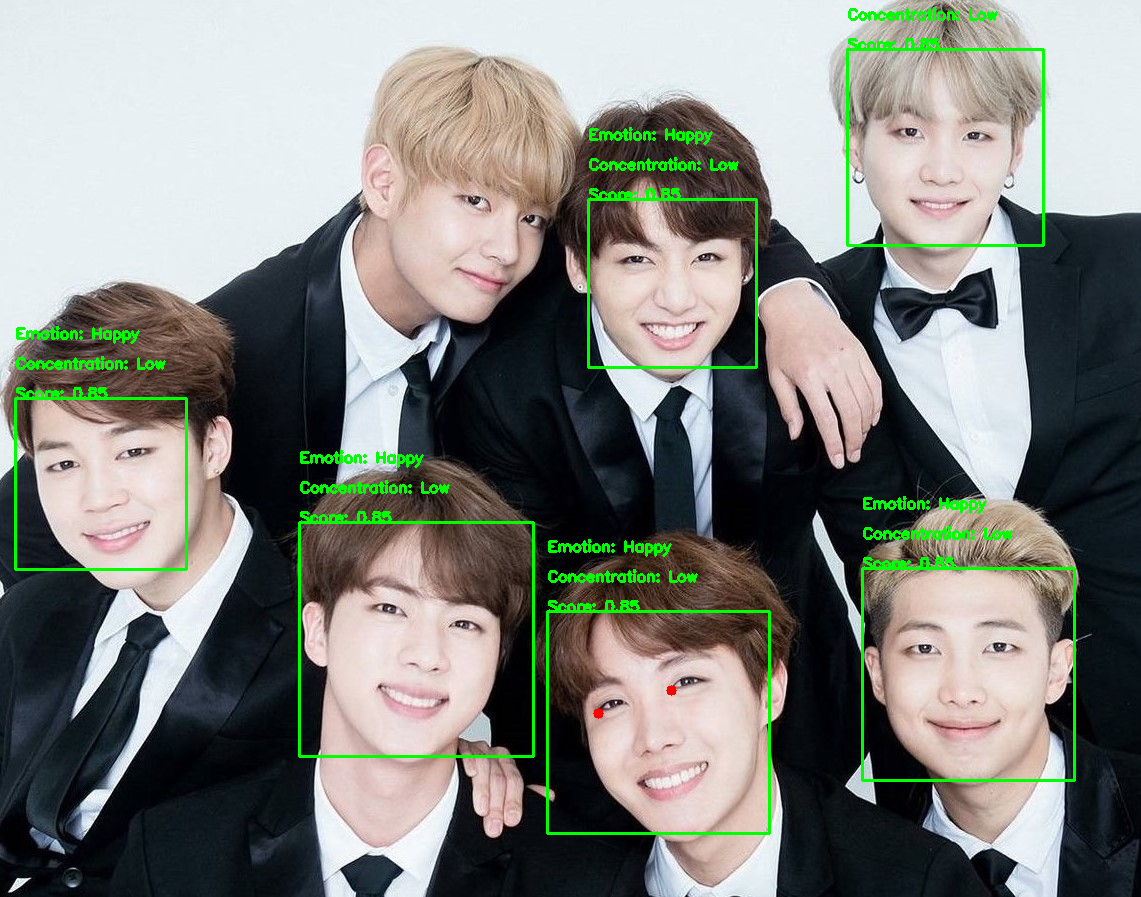

In [ ]:
# Create a list to store information about detected faces
detected_faces_info = []

# For each detected face, find facial landmarks, eye coordinates, emotions, and concentration
for (x, y, w, h) in faces:
    # Convert face region to dlib rectangle
    face_rect = dlib.rectangle(x, y, x + w, y + h)

    # Find facial landmarks
    landmarks = landmark_predictor(gray_img, face_rect)

    # Extract eye coordinates
    left_eye_x = landmarks.part(36).x
    left_eye_y = landmarks.part(36).y
    right_eye_x = landmarks.part(42).x
    right_eye_y = landmarks.part(42).y

    # Recognize emotions
    emotion_label = recognize_emotion(img[y:y+h, x:x+w], emotion_model)


    emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    scores = [0.1, 0.05, 0.03, 0.85, 0.1, 0.2, 0.15]

    # Combine emotions and scores into a dictionary
    emotion_info = dict(zip(emotions, scores))

    # Append the information to the list
    detected_faces_info.append((x, y, w, h, emotion_info))

    # Calculate gaze direction
    gaze_direction = "Looking Forward"

    if left_eye_x < right_eye_x - 20:
        gaze_direction = "Looking Left"
    elif right_eye_x > left_eye_x + 20:
        gaze_direction = "Looking Right"

    # Estimate concentration level
    concentration_level = estimate_concentration(landmarks, gaze_direction)

# Loop through the detected faces and their information
for (x, y, w, h, emotion_info) in detected_faces_info:
    # Draw bounding box around the face
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Draw circles at the eye coordinates
    cv2.circle(img, (left_eye_x, left_eye_y), 5, (0, 0, 255), -1)
    cv2.circle(img, (right_eye_x, right_eye_y), 5, (0, 0, 255), -1)


    # Display emotion above, concentration in the middle, and score below
    text_emotion = f'Emotion: {max(emotion_info, key=emotion_info.get)}'  # Get the emotion with the highest score
    text_score = f'Score: {max(emotion_info.values()):.2f}'  # Get the score of the highest-scoring emotion
    text_concentration = f'Concentration: {concentration_level}'
    text_y_offset = 30  # Vertical offset between lines of text

    cv2.putText(img, text_emotion, (x, y - text_y_offset * 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.putText(img, text_concentration, (x, y - text_y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.putText(img, text_score, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the modified image with face bounding boxes, eye coordinates, emotions, concentration, and scores
cv2_imshow(img)
